In [2]:
%cd /content
!git clone -b v1.0 https://github.com/camenduru/LLaVA
%cd /content/LLaVA

!pip install -q transformers==4.36.2
!pip install -q gradio .

from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch

model_path = "4bit/llava-v1.5-13b-3GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

import os
import requests
from PIL import Image
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def caption_image(image_file, prompt):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

/content
Cloning into 'LLaVA'...
remote: Enumerating objects: 1960, done.
remote: Total 1960 (delta 0), reused 0 (delta 0), pack-reused 1960
Receiving objects: 100% (1960/1960), 13.60 MiB | 24.35 MiB/s, done.
Resolving deltas: 100% (1173/1173), done.
/content/LLaVA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 16.6 MB/s eta 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00009.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00009.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00004-of-00009.bin:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

pytorch_model-00005-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00006-of-00009.bin:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

pytorch_model-00007-of-00009.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

pytorch_model-00008-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00009-of-00009.bin:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [18]:
!mkdir /content/scicap-sample-images
%cd /content/scicap-sample-images
# For now manually download the below images and upload to /content/scicap-sample-images
!wget -q 'https://github.com/tingyaohsu/SciCap/blob/main/img/fig_type_stats.png'  # Replace with the actual URL
!wget -q 'https://github.com/tingyaohsu/SciCap/blob/main/img/figure-example.png'
!wget -q 'https://github.com/tingyaohsu/SciCap/blob/main/img/overview-larger-font.png'
!wget -q 'https://github.com/tingyaohsu/SciCap/blob/main/img/table_with_datasize.png'
!wget -q 'https://github.com/tingyaohsu/SciCap/blob/main/img/table_with_img%2Btxt.png'

mkdir: cannot create directory ‘/content/scicap-sample-images’: File exists
/content/scicap-sample-images


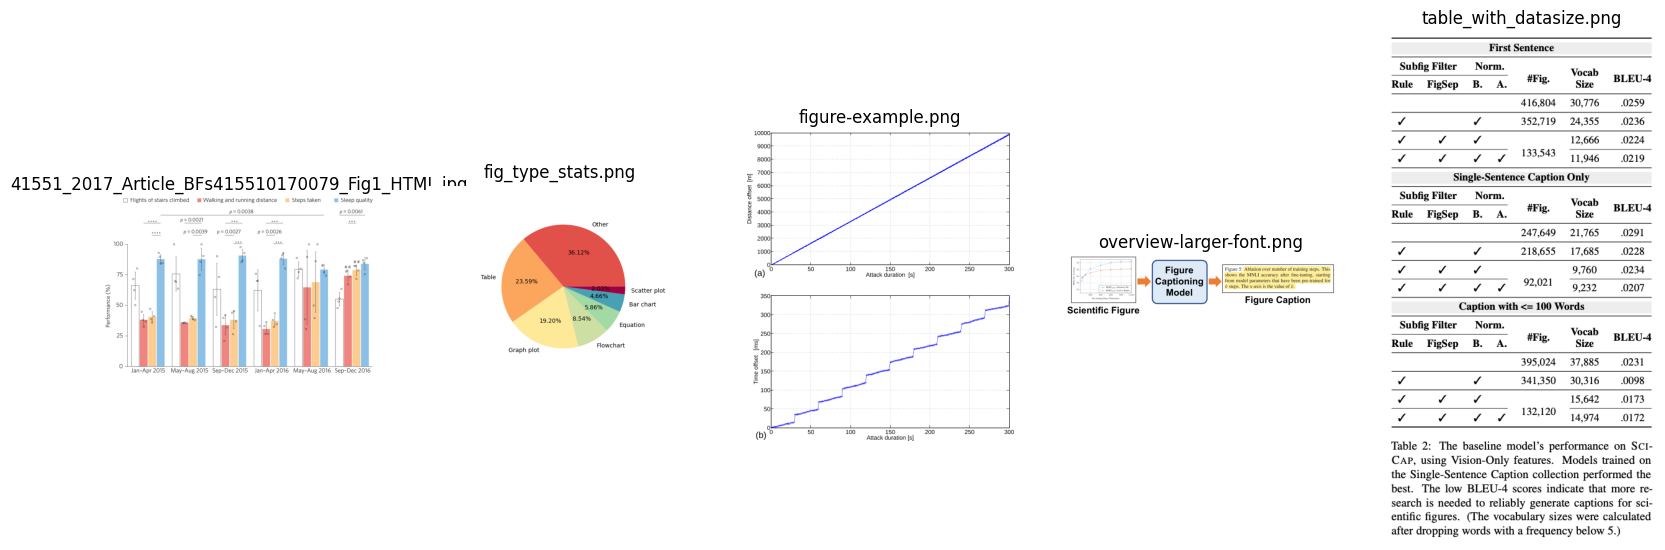

In [44]:
import os
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError # Import UnidentifiedImageError

# Function to display images from a specified directory
def display_images_from_directory(directory_path, num_images=5):
    # Get a list of image files in the directory
    image_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    image_files = sorted(image_files)
    # Display the specified number of images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for img_file, ax in zip(image_files[:num_images], axes):
        img_path = os.path.join(directory_path, img_file)
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(img_file)
            ax.axis('off')
        except UnidentifiedImageError: # Now the exception is recognized
            print(f"Skipping {img_file}: Unable to identify image format.")
    plt.show()

# Specify the directory containing the images
directory_path = '/content/scicap-sample-images'

# Display images
display_images_from_directory(directory_path)

Error processing .ipynb_checkpoints: [Errno 21] Is a directory: '/content/scicap-sample-images/.ipynb_checkpoints'
41551_2017_Article_BFs415510170079_Fig1_HTML.jpg
The graph shows the distance a person can walk or run in a certain time period. The distance is measured in steps and is plotted against the time taken to complete the distance. The graph shows the relationship between the time taken and the distance covered, which can be used to estimate the person's walking or running speed.
fig_type_stats.png
The graph shows a breakdown of various elements, including table, scatter plot, bar chart, equation, and flowchart. The table is the largest section, taking up a significant portion of the graph. The scatter plot is located in the middle, while the bar chart is positioned towards the right side. The equation can be found at the bottom left, and the flowchart is situated at the bottom right. This graph provides a comprehensive overview of the different components and their relationshi

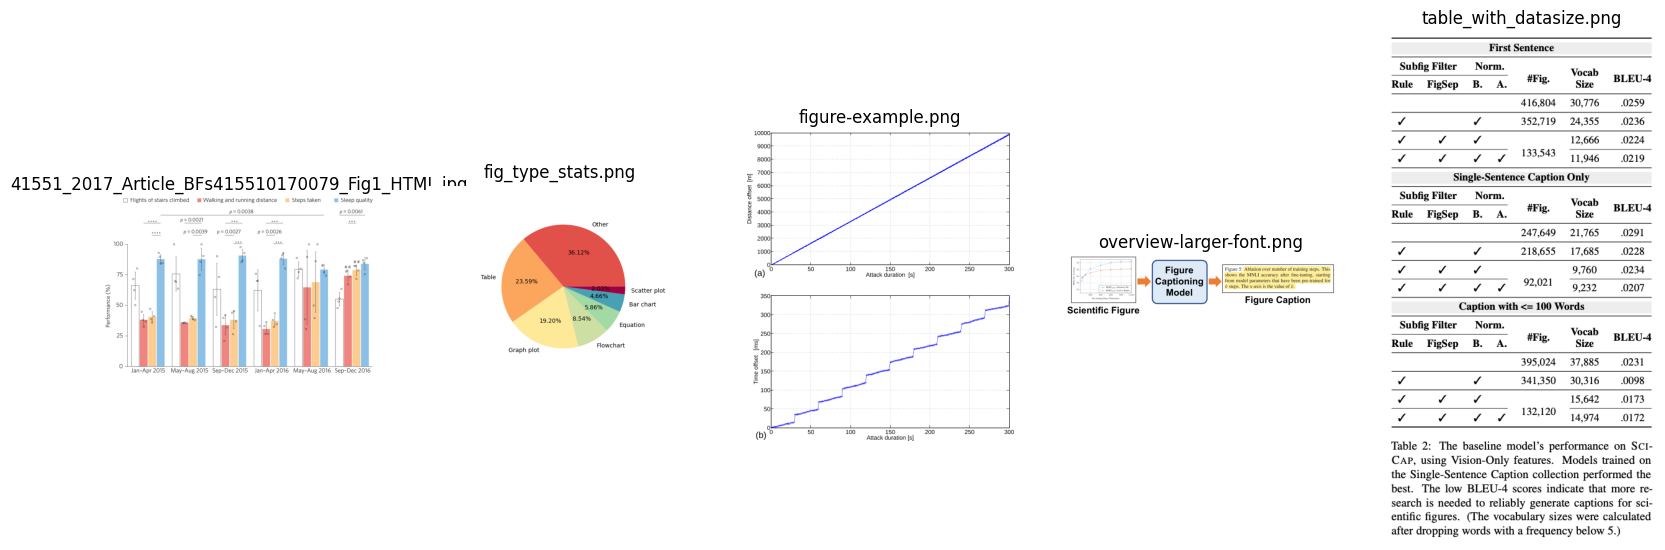

,FileName,Caption
0,41551_2017_Article_BFs415510170079_Fig1_HTML.jpg,The graph shows the distance a person can walk...
1,fig_type_stats.png,The graph shows a breakdown of various element...
2,figure-example.png,The graph shows the effect of distance on the ...
3,overview-larger-font.png,The graph shows a figure of a model of a figur...
4,table_with_datasize.png,The graph shows the number of words in a singl...
5,table_with_img+txt.png,The graph shows the experimental results of mo...


In [48]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

images_path = '/content/scicap-sample-images'
file_names = os.listdir(images_path)
sorted_file_names = sorted(file_names)

# create an empty dataframe with desired columns
df = pd.DataFrame(columns=['FileName', 'Caption'])

# create an empty list to store dictionaries
dict_list = []

for file_name in sorted_file_names:
    try:
        #image, output = caption_image(f'/content/scicap-sample-images/{file_name}', 'Describe the image and color details.')
        image, output = caption_image(f'{images_path}/{file_name}', 'provide a caption for the graph.')

        img = Image.open(f'{images_path}/{file_name}')
        row_dict = {'FileName': file_name, 'Caption': output}
        dict_list.append(row_dict)
        #ax.imshow(img)
        #ax.set_title(file_name)
        #ax.axis('off')
        print(file_name)
        img.show()

        print(output)

    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")
        continue

df = pd.DataFrame(dict_list)


display_images_from_directory(directory_path)
df